In [1]:
!git clone https://github.com/jintn/facemask_keypoint.git

fatal: destination path 'facemask_keypoint' already exists and is not an empty directory.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd facemask_keypoint/models/yolov5/

/content/facemask_keypoint/models/yolov5


In [4]:
!pip install -r requirements.txt

In [5]:
!pip install mediapipe opencv-python-headless

In [6]:
# Run YOLOv5 detect.py script on your images (adjust the --source path as needed)
!python detect.py --weights /content/drive/MyDrive/Facemask_keypoint/Weights/weights/best.pt --source /content/drive/MyDrive/Facemask_keypoint/Data/images/train --conf 0.5 --hide-labels --hide-conf --save-txt --save-conf --project ../runs/detect --name exp

# After running, your detection outputs should be in '../runs/detect/exp'

detect: weights=['/content/drive/MyDrive/Facemask_keypoint/Weights/weights/best.pt'], source=/content/drive/MyDrive/Facemask_keypoint/Data/images/train, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=../runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=True, hide_conf=True, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2025-4-27 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/779 /content/drive/MyDrive/Facemask_keypoint/Data/images/train/maksssksksss1.png: 256x640 8 masks, 1 no mask, 31.3ms
image 2/779 /content/drive/MyDrive/Facemask_keypoint/Data/images/train/maksssksksss10.png: 640x512 1 mask, 33.8ms
image 3/779 /

This cell runs the detect.py script from yolov5 to generate bounding boxes on the dataset. Weights used are from training yolov5 on our dataset.

In [7]:
import cv2
import mediapipe as mp
print(mp.__version__)
import numpy as np
import matplotlib.pyplot as plt


# For inline plotting (if using Colab or Jupyter)
%matplotlib inline

# Initialize MediaPipe FaceMesh in static image mode
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

0.10.21


In [9]:
# Define paths to your image and label file
image_path = '/content/drive/MyDrive/Facemask_keypoint/Data/images/train/maksssksksss10.png'
label_file = '/content/facemask_keypoint/models/runs/detect/exp4/labels/maksssksksss10.txt'

# Load image
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Could not load image at {image_path}")

img_height, img_width = image.shape[:2]

# Read and parse the label file
detections = []
with open(label_file, 'r') as f:
    for line in f:
        # Each line: [class, x_center_norm, y_center_norm, width_norm, height_norm, confidence]
        values = list(map(float, line.strip().split()))
        detections.append(values)

print("Detections:", detections)

Detections: [[0.0, 0.483389, 0.81375, 0.322259, 0.2975, 0.94767]]


In [10]:
def convert_yolo_to_pixels(yolo_line, img_w, img_h):
    """
    Convert a YOLO detection line to pixel coordinates.

    yolo_line: [class, x_center_norm, y_center_norm, width_norm, height_norm, confidence]
    Returns: (x1, y1, x2, y2, cls, conf) in pixel coordinates
    """
    cls, x_center, y_center, w_norm, h_norm, conf = yolo_line

    x_center_pix = x_center * img_w
    y_center_pix = y_center * img_h
    w_pix = w_norm * img_w
    h_pix = h_norm * img_h

    x1 = int(x_center_pix - w_pix / 2)
    y1 = int(y_center_pix - h_pix / 2)
    x2 = int(x_center_pix + w_pix / 2)
    y2 = int(y_center_pix + h_pix / 2)

    # Clip coordinates to image boundaries (optional)
    x1, y1 = max(x1, 0), max(y1, 0)
    x2, y2 = min(x2, img_w - 1), min(y2, img_h - 1)

    return (x1, y1, x2, y2, cls, conf)

Upscaled face crop from (97,119) to (128,157)
Processing detection with crop shape: (157, 128, 3) and dtype: uint8
Processed 1 faces.


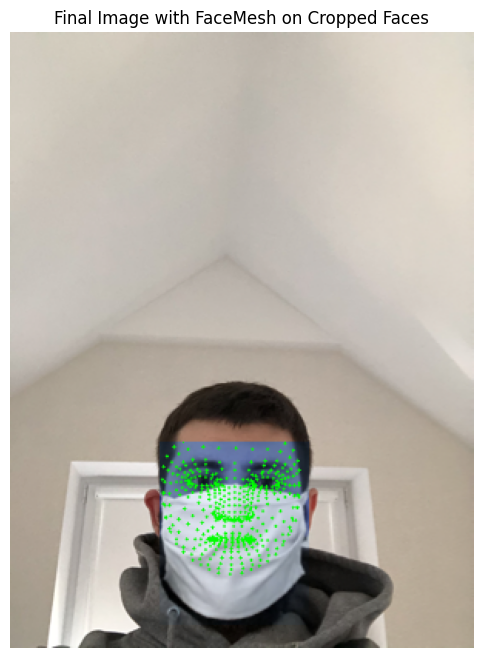

In [11]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# Initialize the older FaceMesh API in static image mode.
face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True)

MIN_SIZE = 128  # Minimum size for upscaling small face crops

# 'image' is your original image loaded without overlays.
results_image = image.copy()
face_count = 0

for det in detections:
    x1, y1, x2, y2, cls, conf = convert_yolo_to_pixels(det, img_width, img_height)

    # (Optional) Filtering: Uncomment if desired.
    # if conf < 0.5:
    #     continue
    # if cls != 0:
    #     continue

    # Crop the face region from the original image
    face_crop = image[y1:y2, x1:x2].copy()

    # Skip if crop is empty or extremely small
    if face_crop.size == 0 or face_crop.shape[0] < 10 or face_crop.shape[1] < 10:
        print("Skipping a detection due to extremely small crop size.")
        continue

    # Convert cropped region from BGR to RGB
    rgb_face = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
    # Ensure the array is contiguous
    rgb_face = np.ascontiguousarray(rgb_face, dtype=np.uint8)

    # Upscale if needed so that both dimensions are at least MIN_SIZE
    h, w = rgb_face.shape[:2]
    if h < MIN_SIZE or w < MIN_SIZE:
        scale = max(MIN_SIZE / h, MIN_SIZE / w)
        new_w = int(w * scale)
        new_h = int(h * scale)
        rgb_face = cv2.resize(rgb_face, (new_w, new_h))
        print(f"Upscaled face crop from ({w},{h}) to ({new_w},{new_h})")

    print("Processing detection with crop shape:", rgb_face.shape, "and dtype:", rgb_face.dtype)

    try:
        # Process the upscaled face crop using the older API.
        mesh_results = face_mesh.process(rgb_face.copy())
    except Exception as e:
        print("Error processing face crop:", e)
        continue

    # If landmarks are detected, draw them on the upscaled crop.
    if mesh_results.multi_face_landmarks:
        for face_landmarks in mesh_results.multi_face_landmarks:
            fh, fw, _ = rgb_face.shape
            for lm in face_landmarks.landmark:
                cx, cy = int(lm.x * fw), int(lm.y * fh)
                cv2.circle(rgb_face, (cx, cy), 1, (0, 255, 0), -1)

    # Downscale the processed face back to the original bounding box size.
    processed_face = cv2.resize(rgb_face, (x2 - x1, y2 - y1))
    results_image[y1:y2, x1:x2] = processed_face
    face_count += 1

print(f"Processed {face_count} faces.")

# Display the final result.
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))
plt.title('Final Image with FaceMesh on Cropped Faces')
plt.axis('off')
plt.show()

Strømmer utdata som er avkortet til de siste 5000 linjene.
Upscaled face crop in maksssksksss231.png from (19,23) to (64,77)
Processing detection in maksssksksss231.png with crop shape: (77, 64, 3)
Upscaled face crop in maksssksksss231.png from (21,26) to (64,79)
Processing detection in maksssksksss231.png with crop shape: (79, 64, 3)
Upscaled face crop in maksssksksss231.png from (22,23) to (64,66)
Processing detection in maksssksksss231.png with crop shape: (66, 64, 3)
Upscaled face crop in maksssksksss231.png from (20,24) to (64,76)
Processing detection in maksssksksss231.png with crop shape: (76, 64, 3)
Upscaled face crop in maksssksksss231.png from (22,26) to (64,75)
Processing detection in maksssksksss231.png with crop shape: (75, 64, 3)
Upscaled face crop in maksssksksss231.png from (23,25) to (64,69)
Processing detection in maksssksksss231.png with crop shape: (69, 64, 3)
Upscaled face crop in maksssksksss231.png from (22,27) to (64,78)
Processing detection in maksssksksss231.p

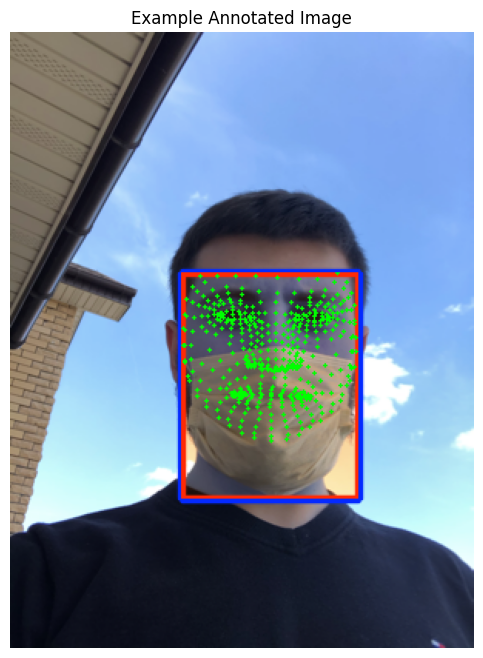

In [13]:
import cv2
import mediapipe as mp
import numpy as np
import os
import matplotlib.pyplot as plt

# Initialize the older FaceMesh API in static image mode with refine_landmarks enabled.
face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True, max_num_faces=5)

# Set the minimum size (in pixels) for processing a face crop.
MIN_SIZE = 64

# Define input and output directories.
input_folder = "/content/facemask_keypoint/models/runs/detect/exp4"
label_folder = os.path.join(input_folder, "labels")
output_folder = "/content/facemask_keypoint/models/runs/detect/facemesh_output"
os.makedirs(output_folder, exist_ok=True)

# Function to convert YOLO normalized coordinates to pixel coordinates.
def convert_yolo_to_pixels(yolo_line, img_w, img_h):
    cls, x_center, y_center, w_norm, h_norm, conf = yolo_line
    x_center_pix = x_center * img_w
    y_center_pix = y_center * img_h
    w_pix = w_norm * img_w
    h_pix = h_norm * img_h
    x1 = int(x_center_pix - w_pix / 2)
    y1 = int(y_center_pix - h_pix / 2)
    x2 = int(x_center_pix + w_pix / 2)
    y2 = int(y_center_pix + h_pix / 2)
    # Clip coordinates to image boundaries.
    x1, y1 = max(x1, 0), max(y1, 0)
    x2, y2 = min(x2, img_w - 1), min(y2, img_h - 1)
    return (x1, y1, x2, y2, cls, conf)

# Get list of image files in the input folder.
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"Found {len(image_files)} images in {input_folder}.")

total_face_count = 0

for img_file in image_files:
    img_path = os.path.join(input_folder, img_file)
    label_path = os.path.join(label_folder, os.path.splitext(img_file)[0] + ".txt")

    # Load the image.
    image = cv2.imread(img_path)
    if image is None:
        print("Failed to load", img_path)
        continue
    img_height, img_width = image.shape[:2]

    # Load detections from the corresponding label file.
    if not os.path.exists(label_path):
        print(f"No label file for {img_file}. Skipping.")
        continue

    detections = []
    with open(label_path, "r") as f:
        for line in f:
            values = list(map(float, line.strip().split()))
            detections.append(values)
    if len(detections) == 0:
        print(f"No detections found in {label_path}.")
        continue

    # Create a copy of the original image for drawing the results.
    results_image = image.copy()
    face_count = 0

    for det in detections:
        x1, y1, x2, y2, cls, conf = convert_yolo_to_pixels(det, img_width, img_height)

        # (Optional) Filtering: Uncomment if needed.
        # if conf < 0.5:
        #     continue
        # if cls != 0:
        #     continue

        # Crop the face region from the original image.
        face_crop = image[y1:y2, x1:x2].copy()

        # Skip if crop is empty or extremely small.
        if face_crop.size == 0 or face_crop.shape[0] < 10 or face_crop.shape[1] < 10:
            print(f"Skipping a detection in {img_file} due to extremely small crop size.")
            continue

        # Convert cropped region from BGR to RGB.
        rgb_face = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
        rgb_face = np.ascontiguousarray(rgb_face, dtype=np.uint8)

        # Upscale if needed so that both dimensions are at least MIN_SIZE.
        h, w = rgb_face.shape[:2]
        if h < MIN_SIZE or w < MIN_SIZE:
            scale = max(MIN_SIZE / h, MIN_SIZE / w)
            new_w = int(w * scale)
            new_h = int(h * scale)
            rgb_face = cv2.resize(rgb_face, (new_w, new_h))
            print(f"Upscaled face crop in {img_file} from ({w},{h}) to ({new_w},{new_h})")

        print(f"Processing detection in {img_file} with crop shape: {rgb_face.shape}")

        try:
            mesh_results = face_mesh.process(rgb_face.copy())
        except Exception as e:
            print(f"Error processing face crop in {img_file}: {e}")
            continue

        # If landmarks are detected, draw them on the upscaled crop.
        if mesh_results.multi_face_landmarks:
            for face_landmarks in mesh_results.multi_face_landmarks:
                fh, fw, _ = rgb_face.shape
                for lm in face_landmarks.landmark:
                    cx, cy = int(lm.x * fw), int(lm.y * fh)
                    cv2.circle(rgb_face, (cx, cy), 1, (0, 255, 0), -1)

        # Downscale the processed face back to the original bounding box size.
        processed_face = cv2.resize(rgb_face, (x2 - x1, y2 - y1))
        results_image[y1:y2, x1:x2] = processed_face
        face_count += 1

    total_face_count += face_count
    out_path = os.path.join(output_folder, img_file)
    cv2.imwrite(out_path, results_image)
    print(f"Saved annotated image for {img_file} with {face_count} faces processed.")

print(f"Total processed faces across images: {total_face_count}")

# Optionally, display one example image.
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))
plt.title("Example Annotated Image")
plt.axis("off")
plt.show()

In [14]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Define paths: the folder where your facemesh-annotated images are saved,
# and an output folder to store the resulting heatmaps.
input_folder = "/content/facemask_keypoint/models/runs/detect/facemesh_output"
heatmap_folder = "/content/facemask_keypoint/models/runs/detect/heatmaps_from_facemesh"
os.makedirs(heatmap_folder, exist_ok=True)

# List image files in the input folder.
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"Found {len(image_files)} images in {input_folder}.")

# Loop over each image.
for img_file in image_files:
    img_path = os.path.join(input_folder, img_file)
    image = cv2.imread(img_path)
    if image is None:
        print(f"Failed to load {img_path}")
        continue

    # Convert the image from BGR to HSV color space.
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define a color range for the drawn landmarks.
    # Adjust these values depending on the color used in your facemesh annotations.
    lower_green = np.array([58, 250, 250])
    upper_green = np.array([62, 255, 255])

    # Create a mask that extracts the green parts (the landmarks).
    mask = cv2.inRange(hsv, lower_green, upper_green)

    nonzero = cv2.countNonZero(mask)

    if nonzero == 0 or nonzero > 0.9 * mask.size:
        print(f"No valid landmarks detected in {img_file}; using blank heatmap.")
        heatmap = np.zeros(mask.shape, dtype=np.float32)
    else:
        # Otherwise, process the mask normally.
        heatmap = mask.astype(np.float32) / 255.0
        # Optionally, apply a Gaussian blur to smooth the heatmap.
        heatmap = cv2.GaussianBlur(heatmap, (0, 0), sigmaX=5, sigmaY=5)
        # Normalize the heatmap so that its maximum value is 1.
        max_val = heatmap.max()
        if max_val > 0:
            heatmap = heatmap / max_val

    # Save the heatmap as a .npy file.
    heatmap_filename = os.path.splitext(img_file)[0] + ".npy"
    heatmap_path = os.path.join(heatmap_folder, heatmap_filename)
    np.save(heatmap_path, heatmap)
    print(f"Saved heatmap for {img_file} to {heatmap_path}")

Found 760 images in /content/facemask_keypoint/models/runs/detect/facemesh_output.
Saved heatmap for maksssksksss685.png to /content/facemask_keypoint/models/runs/detect/heatmaps_from_facemesh/maksssksksss685.npy
Saved heatmap for maksssksksss549.png to /content/facemask_keypoint/models/runs/detect/heatmaps_from_facemesh/maksssksksss549.npy
Saved heatmap for maksssksksss35.png to /content/facemask_keypoint/models/runs/detect/heatmaps_from_facemesh/maksssksksss35.npy
Saved heatmap for maksssksksss703.png to /content/facemask_keypoint/models/runs/detect/heatmaps_from_facemesh/maksssksksss703.npy
Saved heatmap for maksssksksss88.png to /content/facemask_keypoint/models/runs/detect/heatmaps_from_facemesh/maksssksksss88.npy
Saved heatmap for maksssksksss679.png to /content/facemask_keypoint/models/runs/detect/heatmaps_from_facemesh/maksssksksss679.npy
Saved heatmap for maksssksksss73.png to /content/facemask_keypoint/models/runs/detect/heatmaps_from_facemesh/maksssksksss73.npy
No valid land

In [15]:
# ====  Label sanity checker ===============================================
import os, glob
nc = 3                                  # number of classes

bad = []
for path in glob.glob(os.path.join(label_folder, '*.txt')):
    with open(path) as f:
        for ln in f:
            vals = list(map(float, ln.split()))
            if len(vals) >= 6:           # detector labels -> drop conf
                vals = vals[:5]
            if len(vals) != 5:
                bad.append((path, ln.strip(), 'len'));  continue
            cls, xc, yc, w, h = vals
            if cls < 0 or cls >= nc or not (
                0 <= xc <= 1 and 0 <= yc <= 1 and
                0 <= w  <= 1 and 0 <= h  <= 1):
                bad.append((path, ln.strip(), 'range'))

print(f'Checked {len(glob.glob(os.path.join(label_folder, "*.txt")))} files')
print(f'Found {len(bad)} bad label lines')
for p, ln, why in bad[:15]:
    print(f' ➜ {p} :: {ln}  ({why})')

Checked 760 files
Found 0 bad label lines


In [16]:
import cv2
import numpy as np
import os
from torch.utils.data import Dataset

# Define your fixed resize function
def fixed_resize(combined_input, target_size=(640, 640)):
    # combined_input shape is (H, W, 4)
    resized = cv2.resize(combined_input, target_size)
    return resized

class FacemaskDataset(Dataset):
    def __init__(self, image_folder, heatmap_folder, label_folder=None, transform=None):
        """
        Args:
          image_folder: Directory with RGB images.
          heatmap_folder: Directory with corresponding heatmaps (.npy files).
          label_folder: Directory with label files (optional).
          transform: Optional additional transform applied to both image and heatmap.
        """
        self.image_folder = image_folder
        self.heatmap_folder = heatmap_folder
        self.label_folder = label_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_folder)
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if label_folder is not None:
            self.label_paths = [os.path.join(label_folder,
                               os.path.splitext(f)[0] + ".txt")
                               for f in self.image_files]
        else:
            self.label_paths = [None] * len(self.image_files)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image.
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_filename)
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Could not load image at {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Determine the expected heatmap path.
        heatmap_filename = os.path.splitext(img_filename)[0] + ".npy"
        heatmap_path = os.path.join(self.heatmap_folder, heatmap_filename)

        # Check if the heatmap file exists; if not, use a blank heatmap.
        if os.path.exists(heatmap_path):
            heatmap = np.load(heatmap_path)  # Expected shape: (H, W)
        else:
            print(f"Heatmap not found for {img_filename}. Using blank heatmap.")
            heatmap = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)

        # Add a channel dimension if needed so that heatmap becomes (H, W, 1)
        if heatmap.ndim == 2:
            heatmap = heatmap[..., np.newaxis]

        # Optionally apply transforms (if any).
        if self.transform:
            image = self.transform(image)
            heatmap = self.transform(heatmap)

        # Concatenate along the channel axis to get a (H, W, 4) input.
        combined_input = np.concatenate([image, heatmap], axis=-1)

        # Resize the combined input to a fixed size (e.g., 640x640).
        combined_input = fixed_resize(combined_input, target_size=(640, 640))
        # print("After resize, shape:", combined_input.shape)

        # Ensure the array is contiguous.
        combined_input = np.ascontiguousarray(combined_input)

        # Optionally load labels.
        label = None
        if self.label_folder is not None:
            label_filename = os.path.splitext(img_filename)[0] + ".txt"
            label_path = os.path.join(self.label_folder, label_filename)
            if os.path.exists(label_path):
                with open(label_path, "r") as f:
                    lines = f.readlines()
                label = []
                for l in lines:
                    parts = list(map(float, l.strip().split()))
                    label.append(parts)
                label = np.array(label)
            else:
                label = np.zeros((0, 5), dtype=np.float32)

        return combined_input, label


Dataset contains 779 samples.
Combined input shape (H x W x 4): (640, 640, 4)


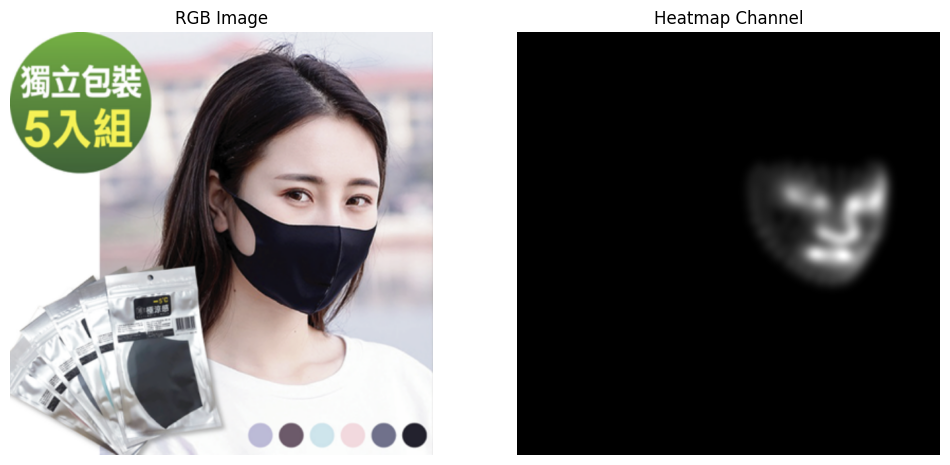

In [17]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Instantiate the dataset.
# Adjust the paths as needed.
image_folder = "/content/drive/MyDrive/Facemask_keypoint/Data/images/train"  # your RGB images folder
heatmap_folder = "/content/facemask_keypoint/models/runs/detect/heatmaps_from_facemesh"  # heatmaps folder
label_folder = "/content/drive/MyDrive/Facemask_keypoint/Data/labels/train"  # optional labels folder

# Create an instance of your FacemaskDataset
dataset = FacemaskDataset(image_folder, heatmap_folder, label_folder=label_folder, transform=None)

# Print dataset size
print("Dataset contains", len(dataset), "samples.")

# Get a sample (at index 0 for example)
sample, label = dataset[0]
print("Combined input shape (H x W x 4):", sample.shape)

# Visualize the sample:
# Extract the RGB image (first 3 channels) and the heatmap (4th channel)
rgb_image = sample[..., :3].astype(np.uint8)
heatmap = sample[..., 3]  # heatmap is a 2D array

# Optionally, normalize the heatmap for better visualization if not already in [0,1]
if heatmap.max() > 1:
    heatmap = heatmap / heatmap.max()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(rgb_image)
plt.title("RGB Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='gray')
plt.title("Heatmap Channel")
plt.axis("off")

plt.show()

In [21]:
!cd /content/facemask_keypoint/models/yolov5

In [22]:
import torch
import yaml
import sys
sys.path.insert(0, "/content/facemask_keypoint/models/yolov5/models")
from yolo import Model


# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to your model configuration YAML file (e.g., yolov5n.yaml)
cfg = "/content/facemask_keypoint/models/yolov5/models/yolov5n.yaml"

# Check if the YAML file exists
import os
print("YAML exists:", os.path.exists(cfg))

# Number of classes (update if needed)
nc = 3

# Anchors can be loaded from your hyperparameter settings; here we pass None
anchors = None

# Instantiate the model with 4 input channels instead of 3.
model = Model(cfg, ch=4, nc=nc, anchors=anchors).to(device)
model.eval()  # set model to evaluation mode

print("Model instantiated with 4 input channels:")
print(model)

Overriding model.yaml nc=80 with nc=3

                 from  n    params  module                                  arguments                     
  0                -1  1      2336  models.common.Conv                      [4, 16, 6, 2, 2]              
  1                -1  1      4672  models.common.Conv                      [16, 32, 3, 2]                
  2                -1  1      4800  models.common.C3                        [32, 32, 1]                   
  3                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  4                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  5                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  6                -1  3    156928  models.common.C3                        [128, 128, 3]                 
  7                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]             

YAML exists: True


YOLOv5n summary: 214 layers, 1768552 parameters, 1768552 gradients, 4.4 GFLOPs



Model instantiated with 4 input channels:
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(4, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3(
      (cv1): Conv(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
     

In [23]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms as T
import numpy as np

# Define the device:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get a sample from your dataset
sample, label = dataset[0]  # assuming dataset returns (image, label)

# Visualize the channels: first three for RGB, last for heatmap.
rgb_image = sample[..., :3].astype('uint8')
heatmap = sample[..., 3].astype('float32')

# Optional: Normalize heatmap for better visualization if it's mostly 0
if heatmap.max() > 1:
    heatmap = heatmap / heatmap.max()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_image)
plt.title("RGB Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='gray')
plt.title("Heatmap Channel")
plt.axis("off")
plt.show()

# Convert sample to tensor, permute to CHW, normalize, and resize
sample_tensor = torch.from_numpy(sample).float().permute(2, 0, 1) / 255.0  # [4, H, W]

# Resize to dimensions divisible by 32
resize = T.Resize((320, 416))  # Adjust this if needed
sample_tensor = resize(sample_tensor)

# Add batch dimension
sample_tensor = sample_tensor.unsqueeze(0)  # [1, 4, H, W]
print("Tensor shape (should be 1 x 4 x H x W):", sample_tensor.shape)

# Move tensor to device and pass it through the model
sample_tensor = sample_tensor.to(device)
with torch.no_grad():
    output = model(sample_tensor)

print("Model output type:", type(output))
print("Model output:", output)
print("------------Output[0] shape:", output[0].shape)



Tensor shape (should be 1 x 4 x H x W): torch.Size([1, 4, 320, 416])
Model output type: <class 'tuple'>
Model output: (tensor([[[3.82571e+00, 4.34276e+00, 1.05831e+01,  ..., 2.16652e-01, 2.47772e-01, 2.30100e-01],
         [1.18257e+01, 4.34276e+00, 1.05831e+01,  ..., 2.16652e-01, 2.47772e-01, 2.30101e-01],
         [1.98257e+01, 4.34276e+00, 1.05831e+01,  ..., 2.16653e-01, 2.47772e-01, 2.30101e-01],
         ...,
         [3.36884e+02, 3.03153e+02, 3.57138e+02,  ..., 2.31957e-01, 2.38905e-01, 2.31017e-01],
         [3.68884e+02, 3.03153e+02, 3.57138e+02,  ..., 2.31957e-01, 2.38905e-01, 2.31017e-01],
         [4.00884e+02, 3.03153e+02, 3.57138e+02,  ..., 2.31957e-01, 2.38905e-01, 2.31017e-01]]], device='cuda:0'), [tensor([[[[[-0.04358,  0.08574,  0.05750,  ..., -1.28529, -1.11053, -1.20774],
           [-0.04358,  0.08574,  0.05750,  ..., -1.28528, -1.11053, -1.20774],
           [-0.04358,  0.08574,  0.05750,  ..., -1.28528, -1.11053, -1.20774],
           ...,
           [-0.04358,  

In [24]:
# %% [code]
import torch
from torch.utils.data import DataLoader

def custom_collate_fn(batch):
    """
    Custom collate function that converts each sample’s combined input (H, W, 4) to a tensor with shape (4, H, W)
    and then stacks them along a new batch dimension.
    It leaves labels as a list (if their shape may vary) or converts them suitably.
    """
    inputs = []
    labels = []
    for combined_input, label in batch:
        # combined_input is a NumPy array with shape (H, W, 4) that has already been resized.
        # Convert it to a tensor and then change to channel-first order (4, H, W)
        tensor = torch.from_numpy(combined_input).permute(2, 0, 1).float()
        inputs.append(tensor)

        # For labels, we simply convert to a tensor if they are not empty; otherwise, use an empty tensor.
        # (You may need to adjust this depending on your actual label format.)
        if label is None or len(label) == 0:
            labels.append(torch.empty(0))
        else:
            labels.append(torch.from_numpy(label).float())

    # All inputs should have the same shape ([4, 640, 640]); so stack them along the batch dimension.
    inputs = torch.stack(inputs, dim=0)
    return inputs, labels

# Now create your DataLoader using this custom collate function:
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=custom_collate_fn)

# For sanity-check, print the shape of a batch.
for batch_inputs, batch_labels in dataloader:
    print("Batch inputs shape:", batch_inputs.shape)  # should be (8, 4, 640, 640)
    break

Batch inputs shape: torch.Size([8, 4, 640, 640])
Heatmap not found for maksssksksss309.png. Using blank heatmap.


Model Training

In [25]:
# ════════════════════════════════════════════════════════════════════════
#   REAL YOLOv5 TRAINING LOOP  (4-channel inputs, no live mAP section)
# ════════════════════════════════════════════════════════════════════════
import os, yaml, torch, torch.optim as optim
from utils.loss import ComputeLoss
from utils.general import non_max_suppression          # handy later

# ── 1. attach a hyp dict so ComputeLoss() can read weightings ───────────
hyp_path = "/content/facemask_keypoint/models/yolov5/data/hyps/hyp.scratch-low.yaml"
with open(hyp_path) as f:
    model.hyp = yaml.safe_load(f)

# ── 2. build criterion + optimiser ──────────────────────────────────────
criterion  = ComputeLoss(model)                       # box + obj + cls losses
optimizer  = optim.Adam(model.parameters(), lr=model.hyp.get('lr0', 1e-3))

# ── 3. helper to read label txts and build YOLO target tensor ───────────
def build_targets(txt_paths, batch_start_idx):
    rows = []
    for local_idx, p in enumerate(txt_paths):
        if p is None or not os.path.exists(p):
            continue                                  # missing label ⇒ skip
        with open(p) as f:
            for ln in f:
                vals = list(map(float, ln.split()))
                if len(vals) >= 6:                    # drop conf if present
                    vals = vals[:5]
                if len(vals) != 5:
                    continue                          # malformed; drop
                cls, xc, yc, w, h = vals
                rows.append([batch_start_idx + local_idx,
                             cls, xc, yc, w, h])
    return torch.tensor(rows, dtype=torch.float32)

# ── 4. training loop ────────────────────────────────────────────────────
num_epochs = 15
save_dir   = "/content/facemask_yolo_ckpts"
os.makedirs(save_dir, exist_ok=True)
best_loss  = float("inf")

for epoch in range(num_epochs):
    model.train()
    running = 0.0

    for bi, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)                 # (B, 4, 640, 640)
        bsz  = imgs.size(0)

        # slice matching txt paths and build target tensor
        start     = bi * dataloader.batch_size
        tgt_paths = dataset.label_paths[start : start + bsz]
        targets   = build_targets(tgt_paths, 0).to(device)

        if targets.numel() == 0:               # batch has no labels
            continue

        preds = model(imgs)
        loss, _ = criterion(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item()

    avg_loss = running / max(1, len(dataloader))
    print(f"Epoch {epoch+1:3}/{num_epochs}   train_loss = {avg_loss:.4f}")

    # checkpoint: keep the weights with the lowest epoch loss
    if avg_loss < best_loss:
        best_loss = avg_loss
        ckpt = os.path.join(save_dir, f"best_loss_{best_loss:.4f}.pt")
        torch.save(model.state_dict(), ckpt)
        print(f"   ↳ saved new best weights to {ckpt}")

print("✔ Training finished. Best epoch loss:", best_loss)

Heatmap not found for maksssksksss258.png. Using blank heatmap.
Heatmap not found for maksssksksss741.png. Using blank heatmap.
Heatmap not found for maksssksksss525.png. Using blank heatmap.
Heatmap not found for maksssksksss748.png. Using blank heatmap.
Heatmap not found for maksssksksss309.png. Using blank heatmap.
Heatmap not found for maksssksksss496.png. Using blank heatmap.
Heatmap not found for maksssksksss659.png. Using blank heatmap.
Heatmap not found for maksssksksss830.png. Using blank heatmap.
Heatmap not found for maksssksksss658.png. Using blank heatmap.
Heatmap not found for maksssksksss484.png. Using blank heatmap.
Heatmap not found for maksssksksss815.png. Using blank heatmap.
Heatmap not found for maksssksksss112.png. Using blank heatmap.
Heatmap not found for maksssksksss562.png. Using blank heatmap.
Heatmap not found for maksssksksss132.png. Using blank heatmap.
Heatmap not found for maksssksksss761.png. Using blank heatmap.
Heatmap not found for maksssksksss406.pn

KeyboardInterrupt: 

Dummy Loss

In [ ]:
# %% [code]
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# Set the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define the paths to your image, heatmap, and (optional) label folders.
image_folder = "/content/drive/MyDrive/Facemask_keypoint/Data/images/train"  # update path if necessary
heatmap_folder = "/content/facemask_keypoint/models/runs/detect/heatmaps_from_facemesh"
label_folder = "/content/drive/MyDrive/Facemask_keypoint/Data/labels/train"  # if labels are available

# Instantiate the dataset.
dataset = FacemaskDataset(image_folder, heatmap_folder, label_folder=label_folder, transform=None)
print(f"Dataset contains {len(dataset)} samples.")

# Create the DataLoader using the custom collate function.
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=custom_collate_fn)

# %% [code]
# Import the YOLOv5 model.
import sys
sys.path.insert(0, "/content/facemask_keypoint")  # add your repo root to path
from yolo import Model  # This should load the Model class from models/yolov5/models/yolo.py

# Path to your model YAML configuration file (e.g., yolov5n.yaml)
cfg = "/content/facemask_keypoint/models/yolov5/models/yolov5n.yaml"

# Set the number of classes for your facemask dataset.
nc = 3

# Use default anchors from YAML (pass None if you want to use those).
anchors = None

# Instantiate the YOLOv5 model with 4 input channels.
model = Model(cfg, ch=4, nc=nc, anchors=anchors).to(device)
model.train()  # set model to training mode
print("Model instantiated with 4 input channels.")
print(model)

# %% [code]
# Create an optimizer.
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define number of epochs for training.
num_epochs = 5  # Change as needed

for epoch in range(num_epochs):
    total_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloader):
        # 'inputs' are now already torch tensors with shape (B, 4, H, W) because of our custom collate.
        inputs = inputs.to(device)

        # If your dataset returns labels in a custom format and you wish to use them,
        # you can process/move them to device here. For our dummy loss we ignore them.

        optimizer.zero_grad()

        # Forward pass.
        outputs = model(inputs)
        # Depending on your model's forward pass, it may return a tuple.
        # Here, if it returns a tuple, we take the first element.
        out = outputs[0] if isinstance(outputs, (list, tuple)) else outputs

        # Dummy loss: compute MSE loss between the model output and a zero tensor.
        dummy_target = torch.zeros_like(out)
        loss = F.mse_loss(out, dummy_target)

        # Backward pass.
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print("Training finished.")

Overriding model.yaml nc=80 with nc=3

                 from  n    params  module                                  arguments                     
  0                -1  1      2336  models.common.Conv                      [4, 16, 6, 2, 2]              
  1                -1  1      4672  models.common.Conv                      [16, 32, 3, 2]                
  2                -1  1      4800  models.common.C3                        [32, 32, 1]                   
  3                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  4                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  5                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  6                -1  3    156928  models.common.C3                        [128, 128, 3]                 
  7                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]             

Using device: cuda
Dataset contains 778 samples.


YOLOv5n summary: 214 layers, 1768552 parameters, 1768552 gradients, 4.4 GFLOPs



Model instantiated with 4 input channels.
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(4, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3(
      (cv1): Conv(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
     